# GAN (Generative Adversarial Network) : 생산적 적대 신경망

- Generator(생성자) 와 Discriminator(판별자) 가 서로 Adversarial(경쟁) 하는 형태

- 학습 과정

    Generator (G) : z (random noise) 를 입력받아 데이터 생성 G(z) -> D 를 속일 수 있도록 최대한 정교하게 데이터를 생성

    Discriminator (D) : x 와 G(z) 를 이진분류 -> real (x) 와 fake (G(z))를 명확히 판별할 수 있도록 학습

    D training (D, G 모두 사용하지만 D의 weights 만 변경) -> G training (D, G 모두 사용하지만 G의 weights 만 변경) 을 반복 

    *G 는 D 를 속이도록, D 는 G 를 잡아내도록 서로 경쟁*


- 발전

    DCGAN : Deep Convolution GAN -> 학습 안정성 향상

    cGAN : Conditional GAN -> 조건부 생성 (조건에 맞는 데이터 생성)

    WGAN : Wasserstein GAN -> Wasserstein Distance(지구 이동 거리) 를 사용하여 학습 안정성 향상

    PGGAN : ProGressive GAN -> 저해상도부터 고해상도까지 점진적으로 학습

    StyleGAN : Generator가 style transfer를 사용 + PGGAN -> 고품질 이미지 생성


- 평가 지표 (metrics)

    Inception Score (IS)

    Fréchet Inception Distance (FID)

    Kernel Inception Distance (KID)

    Precision : 생성된 샘플 중 실제 데이터와 유사한 샘플의 비율(얼마나 사실적인가)
    
    Recall : 실제 데이터 분포 중 생성 모델이 커버하는 영역의 비율 (얼마나 다양한가)

![gan wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Generative_adversarial_network.svg/375px-Generative_adversarial_network.svg.png)

In [1]:
import torch

from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.nn import Module, Sequential, Linear, ReLU, BatchNorm1d, Tanh, LeakyReLU, Sigmoid, BCELoss
from torch.optim import Adam
from torchvision.utils import make_grid

import os
from time import time
from math import floor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# pin_memory=True : tensor를 cpu의 pin(고정된) memory에 배치 -> gpu로 더 빠르게 옮길 수 있다.
# persistent_workers=True : worker들 재사용 -> process 생성 overhead 방지
trainset = DataLoader(CIFAR10(root="data_cifar10", train=True, download=True, transform=transform),
                      batch_size=64,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True)

In [3]:
class Generator(Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.model = Sequential(
            Linear(latent_size, 256),
            ReLU(),
            BatchNorm1d(256),
            Linear(256, 512),
            ReLU(),
            BatchNorm1d(512),
            Linear(512, 1024),
            ReLU(),
            BatchNorm1d(1024),
            # 28 * 28: image size
            Linear(1024, 32 * 32 * 3),
            Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [4]:
class Discriminator(Module):
    def __init__(self, image_dim):
        super().__init__()

        self.model = Sequential(
            Linear(image_dim, 512),
            LeakyReLU(0.2),
            Linear(512, 256),
            LeakyReLU(0.2),
            Linear(256, 1),
            Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [6]:
latent_size = 128
image_dim = 32 * 32 * 3

G = Generator(latent_size).to(device)
D = Discriminator(image_dim).to(device)

In [7]:
loss_function = BCELoss()

g_learning_rate = 0.0003
d_learning_rate = 0.0001

g_optimizer = Adam(G.parameters(), lr=g_learning_rate)
d_optimizer = Adam(D.parameters(), lr=d_learning_rate)

epoch:   1/30 	 D Loss: 0.412 G Loss: 2.468 	 27s
epoch:   2/30 	 D Loss: 0.287 G Loss: 3.236 	 3s
epoch:   3/30 	 D Loss: 0.293 G Loss: 3.312 	 3s
epoch:   4/30 	 D Loss: 0.289 G Loss: 3.285 	 3s
epoch:   5/30 	 D Loss: 0.295 G Loss: 3.300 	 3s
epoch:   6/30 	 D Loss: 0.324 G Loss: 3.049 	 3s
epoch:   7/30 	 D Loss: 0.392 G Loss: 2.606 	 3s
epoch:   8/30 	 D Loss: 0.481 G Loss: 1.941 	 3s
epoch:   9/30 	 D Loss: 0.550 G Loss: 1.463 	 3s


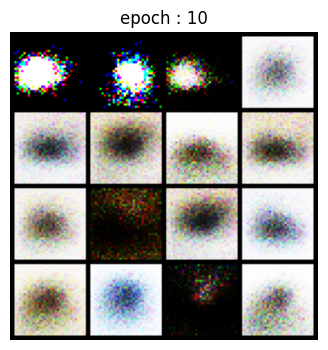

epoch:  10/30 	 D Loss: 0.562 G Loss: 1.397 	 3s
epoch:  11/30 	 D Loss: 0.518 G Loss: 1.620 	 3s
epoch:  12/30 	 D Loss: 0.506 G Loss: 1.716 	 3s
epoch:  13/30 	 D Loss: 0.487 G Loss: 1.866 	 3s
epoch:  14/30 	 D Loss: 0.505 G Loss: 1.662 	 3s
epoch:  15/30 	 D Loss: 0.518 G Loss: 1.555 	 3s
epoch:  16/30 	 D Loss: 0.558 G Loss: 1.369 	 3s
epoch:  17/30 	 D Loss: 0.545 G Loss: 1.444 	 3s
epoch:  18/30 	 D Loss: 0.541 G Loss: 1.468 	 3s
epoch:  19/30 	 D Loss: 0.554 G Loss: 1.441 	 4s


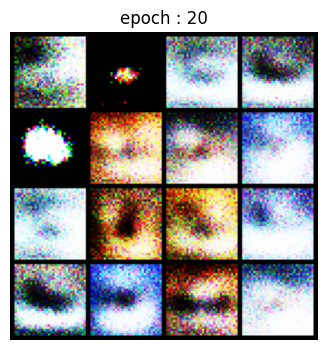

epoch:  20/30 	 D Loss: 0.563 G Loss: 1.312 	 5s
epoch:  21/30 	 D Loss: 0.553 G Loss: 1.385 	 5s
epoch:  22/30 	 D Loss: 0.548 G Loss: 1.486 	 4s
epoch:  23/30 	 D Loss: 0.568 G Loss: 1.303 	 3s
epoch:  24/30 	 D Loss: 0.564 G Loss: 1.306 	 3s
epoch:  25/30 	 D Loss: 0.548 G Loss: 1.355 	 3s
epoch:  26/30 	 D Loss: 0.553 G Loss: 1.407 	 3s
epoch:  27/30 	 D Loss: 0.561 G Loss: 1.302 	 3s
epoch:  28/30 	 D Loss: 0.561 G Loss: 1.271 	 3s
epoch:  29/30 	 D Loss: 0.560 G Loss: 1.315 	 3s


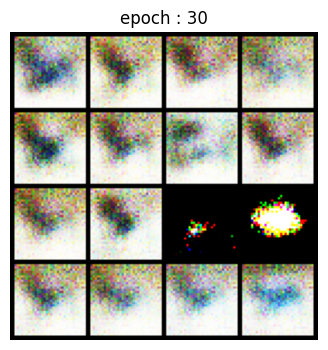

epoch:  30/30 	 D Loss: 0.550 G Loss: 1.385 	 3s
learning time (30 epoch) : 2m 0


In [ ]:
epochs = 30

total_time = list()

d_loss_list = list()
g_loss_list = list()

for epoch in range(1, epochs+1):
    now = time()
    d_avg_loss = 0.0
    g_avg_loss = 0.0

    for i, data in enumerate(trainset):
        x, _ = data
        x = x.view(x.size(0), -1).to(device)

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        batch_size = x.size(0)
        # real_labels = torch.ones(batch_size, device=device).unsqueeze(1) * 0.9 + 0.05 * torch.rand(batch_size, 1, device=device)
        # fake_labels = torch.zeros(batch_size, device=device).unsqueeze(1) + 0.05 * torch.rand(batch_size, 1, device=device)
        real_labels = torch.ones(batch_size, device=device).unsqueeze(1) * 0.9
        fake_labels = torch.zeros(batch_size, device=device).unsqueeze(1) + 0.05
        
        # D training
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = G(z)

        real_loss = loss_function(D(x), real_labels)
        fake_loss = loss_function(D(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # G training
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = G(z)    

        g_loss = loss_function(D(fake_imgs), real_labels)
        g_loss.backward()
        g_optimizer.step()
            
        d_avg_loss += d_loss.item()
        g_avg_loss += g_loss.item()

        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())

    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch:3d}/{epochs} \t D Loss: {d_avg_loss/len(trainset):.3f} G Loss: {g_avg_loss/len(trainset):.3f} \t {learning_time}s")
    
    if epoch % 10 == 0:
        fake_images = fake_imgs.detach().view(-1, 3, 32, 32)
        plt.figure(figsize=(4, 4))
        plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"epoch : {epoch}")
        plt.show()
    

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")

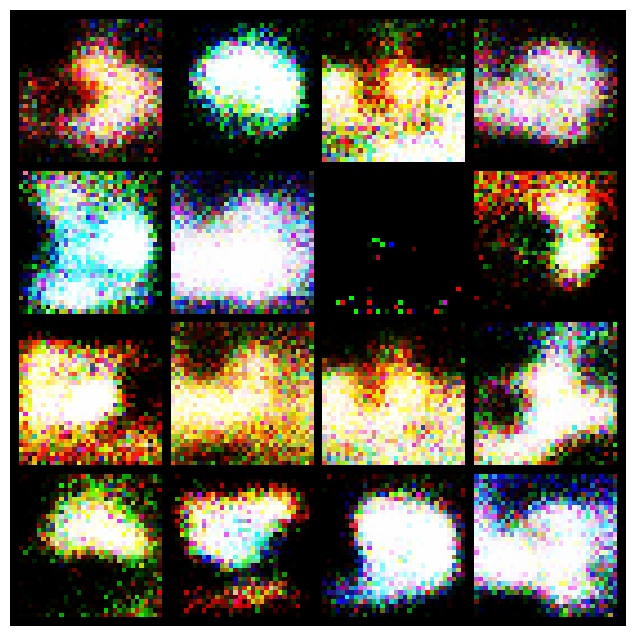

In [9]:
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z).detach().view(-1, 3, 32, 32)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(fake_images[:16], nrow=4, normalize=True).cpu().permute(1,2,0))
plt.axis("off")
plt.show()

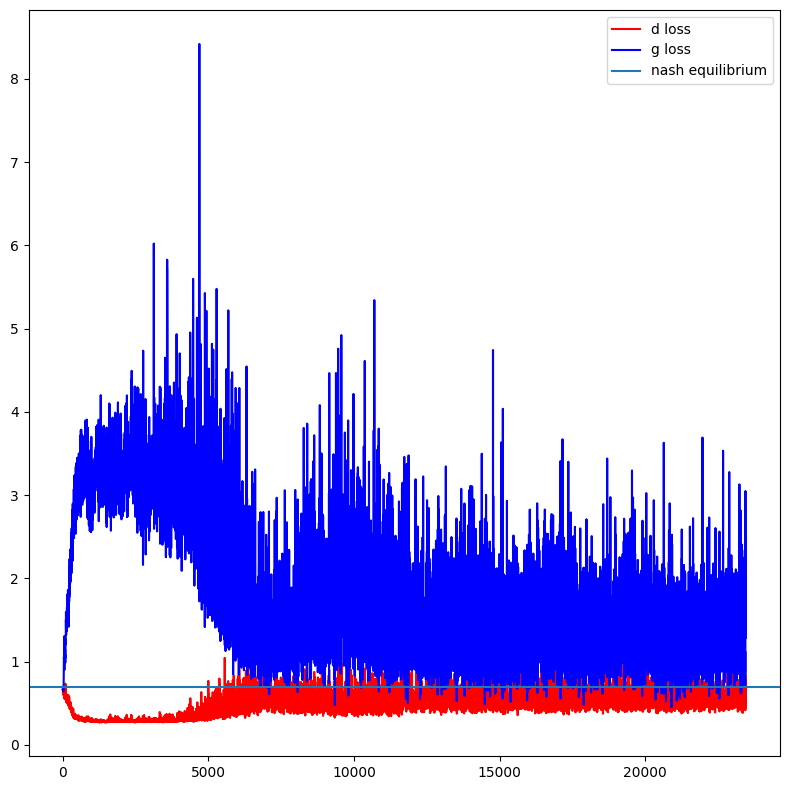

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(d_loss_list) + 1), d_loss_list, label='d loss', color='red')
plt.plot(range(1, len(d_loss_list) + 1), g_loss_list, label='g loss', color='blue')
plt.axhline(y=np.log(2), label='nash equilibrium')
plt.tight_layout()
plt.legend()
plt.show()

vanilla gan (가장 기초적인 gan) 으로는 cifar10 같이 복잡한 color image 학습은 거의 불가!

-> image의 edge, shape 등은 전혀 학습할 수 없는 상황 = spatial information (공간 정보) 가 소실되기 때문

-> 모드 붕괴는 아님!